In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# DATA CLEANING

In [5]:
df = pd.read_csv("freshretail_50k.csv")

In [6]:
df.replace(["NaN", "nan", " ", ""], np.nan, inplace=True)

In [7]:
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(0)

In [8]:
df["dt"] = pd.to_datetime(df["dt"], errors="coerce")

In [9]:
def parse_array(col):
    """Convert stringified list '[0,0,...]' to numpy array"""
    try:
        return np.array(ast.literal_eval(col))
    except:
        return np.zeros(24)

if "hours_sale" in df.columns:
    df["hours_sale_array"] = df["hours_sale"].apply(parse_array)
    df["total_sale_hours"] = df["hours_sale_array"].apply(np.sum)
    df.drop(["hours_sale", "hours_sale_array"], axis=1, inplace=True, errors="ignore")

if "hours_stock_status" in df.columns:
    df["hours_stock_array"] = df["hours_stock_status"].apply(parse_array)
    df["active_stock_hours"] = df["hours_stock_array"].apply(np.sum)
    df.drop(["hours_stock_status", "hours_stock_array"], axis=1, inplace=True, errors="ignore")

In [10]:
cols_all_zero = [col for col in df.columns if (df[col].dtype in ['int64','float64']) and (df[col].sum() == 0)]
df.drop(columns=cols_all_zero, inplace=True)

In [11]:
df.drop_duplicates(inplace=True)

In [12]:
df["year"] = df["dt"].dt.year
df["month"] = df["dt"].dt.month
df["day"] = df["dt"].dt.day
df["weekday"] = df["dt"].dt.day_name()

In [13]:
df_sample = df.sample(n=2000, random_state=42)

In [14]:
print("Null values after cleaning:\n", df_sample.isnull().sum())
print("\nRemoved all-zero columns:", cols_all_zero)
print("\nShape after sampling:", df_sample.shape)

Null values after cleaning:
 store_id               0
management_group_id    0
first_category_id      0
second_category_id     0
third_category_id      0
product_id             0
dt                     0
sale_amount            0
stock_hour6_22_cnt     0
discount               0
holiday_flag           0
activity_flag          0
precpt                 0
avg_temperature        0
avg_humidity           0
avg_wind_level         0
year                   0
month                  0
day                    0
weekday                0
dtype: int64

Removed all-zero columns: ['city_id', 'total_sale_hours', 'active_stock_hours']

Shape after sampling: (2000, 20)


In [15]:
df_sample.to_csv("freshretail_cleaned_2000.csv", index=False)
print("\nCleaned dataset saved as 'freshretail_cleaned_2000.csv'")


Cleaned dataset saved as 'freshretail_cleaned_2000.csv'


In [16]:
df_sample.head()

,store_id,management_group_id,first_category_id,second_category_id,third_category_id,product_id,dt,sale_amount,stock_hour6_22_cnt,discount,holiday_flag,activity_flag,precpt,avg_temperature,avg_humidity,avg_wind_level,year,month,day,weekday
161552,61,4,23,10,17,644,2024-03-30,0.2,0,1.000,1,0,2.0936,16.47,76.59,1.68,2024,3,30,Saturday
219761,91,6,20,50,59,166,2024-06-07,3.6,4,1.000,0,0,1.8132,24.94,73.67,1.57,2024,6,7,Friday
233668,95,6,10,38,173,672,2024-04-25,0.4,0,0.732,0,1,3.6051,20.31,80.29,1.59,2024,4,25,Thursday
38669,18,2,0,13,27,98,2024-05-26,0.9,6,0.820,1,1,0.8557,23.29,67.05,1.98,2024,5,26,Sunday
395808,143,6,24,69,139,645,2024-06-14,2.9,0,0.625,0,1,6.4891,27.09,77.20,1.73,2024,6,14,Friday


# Feature Engineering

In [70]:
df = pd.read_csv("freshretail_cleaned_2000.csv")

In [71]:
# --- Sales-based features ---
df["discount_effect"] = df["discount"] * df["sale_amount"]         
df["avg_stock_sales_ratio"] = df["sale_amount"] / (df["stock_hour6_22_cnt"] + 1) 

In [72]:
# --- Weather-based features ---
df["temp_humidity_ratio"] = df["avg_temperature"] / (df["avg_humidity"] + 1)
df["weather_impact"] = (df["avg_temperature"] * 0.4) + (df["precpt"] * 0.3) - (df["avg_wind_level"] * 0.3)

In [73]:
# --- Time-based features ---
df["is_weekend"] = df["weekday"].isin(["Saturday", "Sunday"]).astype(int)
df["is_holiday_activity"] = df["holiday_flag"] * df["activity_flag"]   

In [74]:
# --- Category or Product features (if available) ---
if "first_category_id" in df.columns and "second_category_id" in df.columns:
    df["category_combo"] = df["first_category_id"].astype(str) + "_" + df["second_category_id"].astype(str)

In [75]:
# --- Derived business indicator ---
df["discount_category_impact"] = df["discount"] * df.get("first_category_id", 1)

In [76]:
# --- Classification target for ML ---
df["sales_level"] = np.where(df["sale_amount"] > df["sale_amount"].median(), 1, 0)

In [77]:
drop_cols = ["management_group_id", "third_category_id"]
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

In [78]:
df.to_csv("freshretail_feature_engineered_2000.csv", index=False)

In [79]:
print("Feature Engineering Completed Successfully")
print("Shape:", df.shape)
print("\nColumns created:")
print([
    "discount_effect", 
    "avg_stock_sales_ratio", 
    "temp_humidity_ratio", 
    "weather_impact", 
    "is_weekend", 
    "is_holiday_activity", 
    "category_combo", 
    "discount_category_impact", 
    "sales_level"
])
print("\n Saved as: freshretail_feature_engineered_2000.csv")

Feature Engineering Completed Successfully
Shape: (2000, 27)

Columns created:
['discount_effect', 'avg_stock_sales_ratio', 'temp_humidity_ratio', 'weather_impact', 'is_weekend', 'is_holiday_activity', 'category_combo', 'discount_category_impact', 'sales_level']

 Saved as: freshretail_feature_engineered_2000.csv


# EDA

In [80]:
df = pd.read_csv("freshretail_feature_engineered_2000.csv")

print(" Data Loaded — Shape:", df.shape)
print("\n Columns:", df.columns.tolist())

 Data Loaded — Shape: (2000, 27)

 Columns: ['store_id', 'first_category_id', 'second_category_id', 'product_id', 'dt', 'sale_amount', 'stock_hour6_22_cnt', 'discount', 'holiday_flag', 'activity_flag', 'precpt', 'avg_temperature', 'avg_humidity', 'avg_wind_level', 'year', 'month', 'day', 'weekday', 'discount_effect', 'avg_stock_sales_ratio', 'temp_humidity_ratio', 'weather_impact', 'is_weekend', 'is_holiday_activity', 'category_combo', 'discount_category_impact', 'sales_level']


In [81]:
print("\n Dataset Summary:\n")
print(df.describe(include="all").T)

print("\n Missing Values:\n", df.isnull().sum())


 Dataset Summary:

                           count unique         top freq      mean  \
store_id                  2000.0    NaN         NaN  NaN   88.9505   
first_category_id         2000.0    NaN         NaN  NaN   14.2995   
second_category_id        2000.0    NaN         NaN  NaN   43.8775   
product_id                2000.0    NaN         NaN  NaN  379.8415   
dt                          2000     90  2024-05-08   34       NaN   
sale_amount               2000.0    NaN         NaN  NaN  1.023425   
stock_hour6_22_cnt        2000.0    NaN         NaN  NaN     3.222   
discount                  2000.0    NaN         NaN  NaN  0.912295   
holiday_flag              2000.0    NaN         NaN  NaN    0.3525   
activity_flag             2000.0    NaN         NaN  NaN    0.4085   
precpt                    2000.0    NaN         NaN  NaN  3.200276   
avg_temperature           2000.0    NaN         NaN  NaN  21.62202   
avg_humidity              2000.0    NaN         NaN  NaN  75.45028   


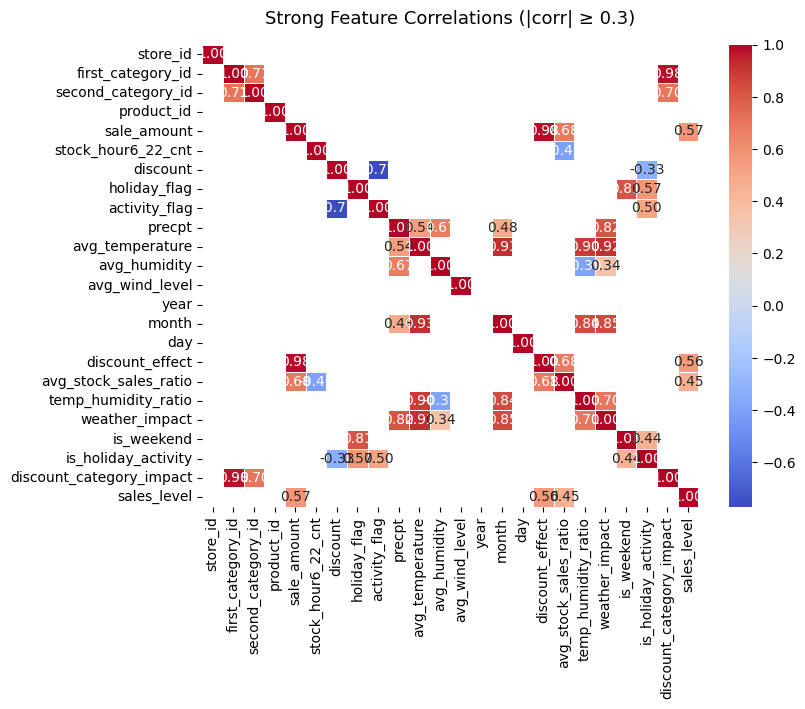

In [83]:
corr = df.corr(numeric_only=True)

strong_corr = corr[(corr >= 0.3) | (corr <= -0.3)]

plt.figure(figsize=(8,6))
sns.heatmap(strong_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Strong Feature Correlations (|corr| ≥ 0.3)", fontsize=13, pad=15)
plt.show()

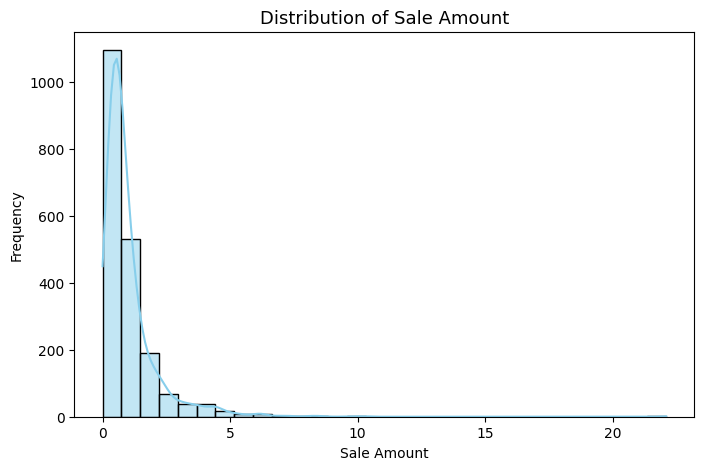

In [84]:
plt.figure(figsize=(8,5))
sns.histplot(df["sale_amount"], bins=30, kde=True, color="skyblue")
plt.title("Distribution of Sale Amount", fontsize=13)
plt.xlabel("Sale Amount")
plt.ylabel("Frequency")
plt.show()

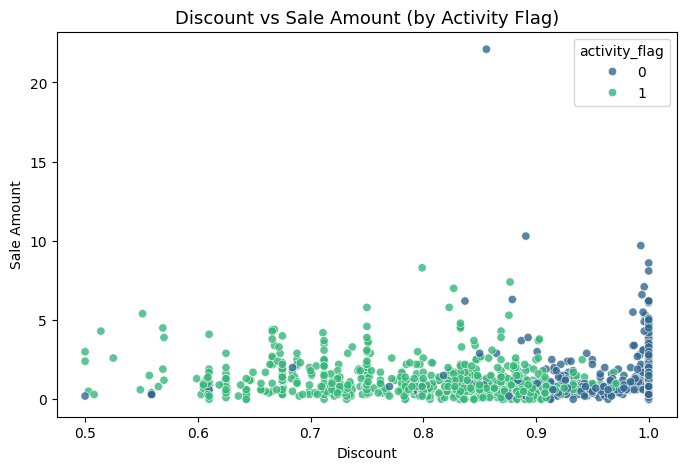

In [85]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="discount", y="sale_amount", data=df, hue="activity_flag", palette="viridis", alpha=0.8)
plt.title("Discount vs Sale Amount (by Activity Flag)", fontsize=13)
plt.xlabel("Discount")
plt.ylabel("Sale Amount")
plt.show()

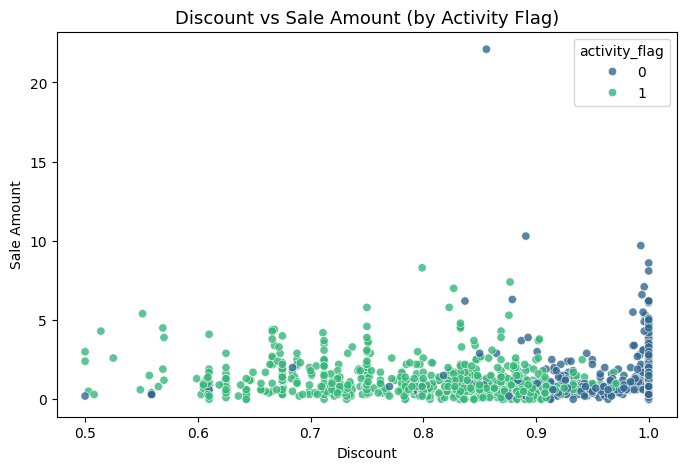

In [86]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="discount", y="sale_amount", data=df, hue="activity_flag", palette="viridis", alpha=0.8)
plt.title("Discount vs Sale Amount (by Activity Flag)", fontsize=13)
plt.xlabel("Discount")
plt.ylabel("Sale Amount")
plt.show()

C:\Users\swati\AppData\Local\Temp\ipykernel_14940\2116531759.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="weekday", y="sale_amount", data=df, order=order, palette="mako")


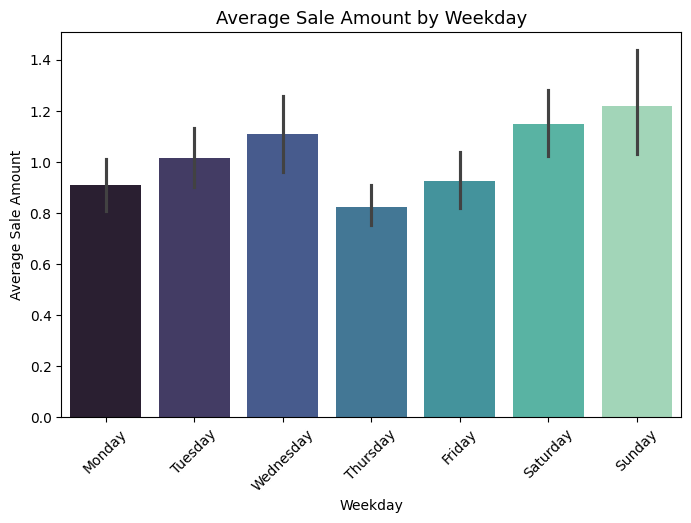

In [87]:
plt.figure(figsize=(8,5))
order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
sns.barplot(x="weekday", y="sale_amount", data=df, order=order, palette="mako")
plt.title("Average Sale Amount by Weekday", fontsize=13)
plt.xlabel("Weekday")
plt.ylabel("Average Sale Amount")
plt.xticks(rotation=45)
plt.show()

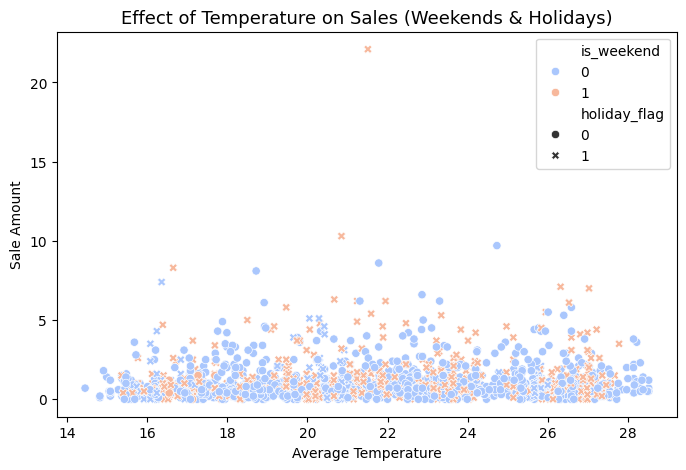

In [88]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="avg_temperature", y="sale_amount", hue="is_weekend", style="holiday_flag", data=df, palette="coolwarm")
plt.title("Effect of Temperature on Sales (Weekends & Holidays)", fontsize=13)
plt.xlabel("Average Temperature")
plt.ylabel("Sale Amount")
plt.show()

C:\Users\swati\AppData\Local\Temp\ipykernel_14940\2991448925.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="sales_level", y="discount_effect", data=df, palette="Set2")


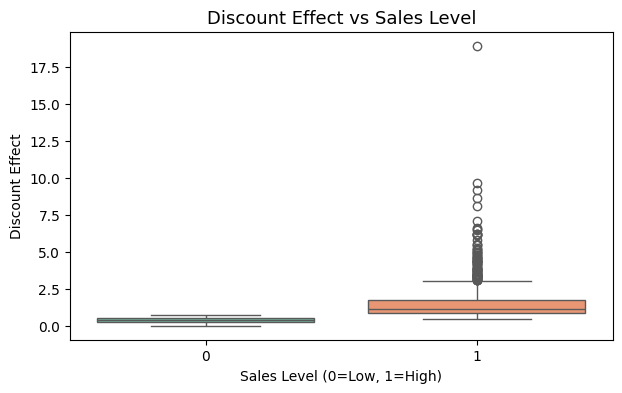

C:\Users\swati\AppData\Local\Temp\ipykernel_14940\2991448925.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="sales_level", y="weather_impact", data=df, palette="flare")


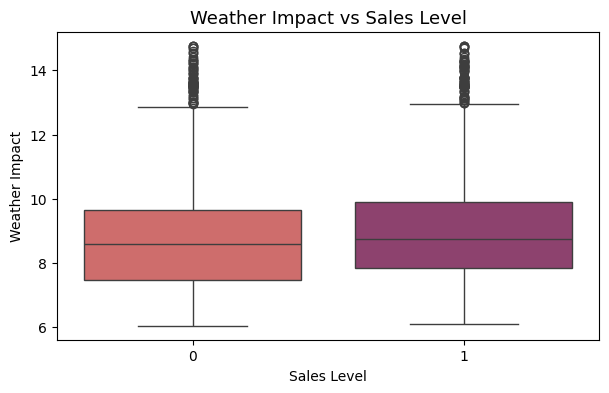

In [90]:
plt.figure(figsize=(7,4))
sns.boxplot(x="sales_level", y="discount_effect", data=df, palette="Set2")
plt.title("Discount Effect vs Sales Level", fontsize=13)
plt.xlabel("Sales Level (0=Low, 1=High)")
plt.ylabel("Discount Effect")
plt.show()

plt.figure(figsize=(7,4))
sns.boxplot(x="sales_level", y="weather_impact", data=df, palette="flare")
plt.title("Weather Impact vs Sales Level", fontsize=13)
plt.xlabel("Sales Level")
plt.ylabel("Weather Impact")
plt.show()

C:\Users\swati\AppData\Local\Temp\ipykernel_14940\4227255103.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cats.values, y=top_cats.index, palette="crest")


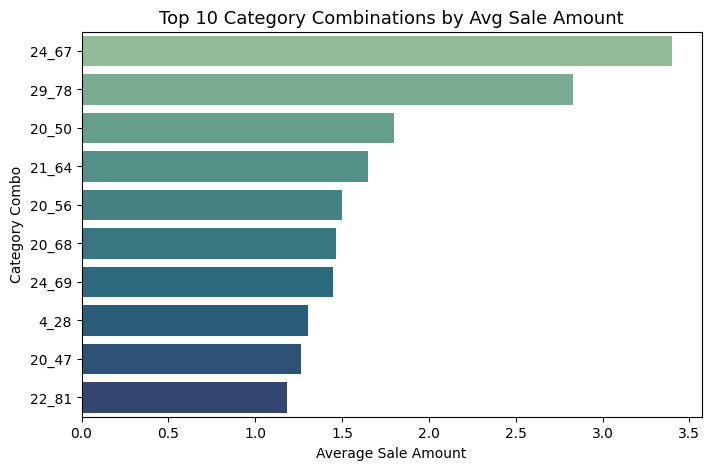

In [91]:
if "category_combo" in df.columns:
    top_cats = df.groupby("category_combo")["sale_amount"].mean().sort_values(ascending=False).head(10)
    plt.figure(figsize=(8,5))
    sns.barplot(x=top_cats.values, y=top_cats.index, palette="crest")
    plt.title("Top 10 Category Combinations by Avg Sale Amount", fontsize=13)
    plt.xlabel("Average Sale Amount")
    plt.ylabel("Category Combo")
    plt.show()

C:\Users\swati\AppData\Local\Temp\ipykernel_14940\2744012448.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_values.values[1:], y=corr_values.index[1:], palette="plasma")


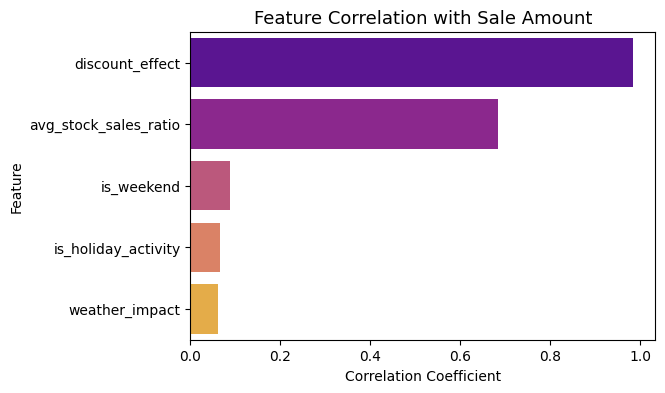


 EDA Complete


In [92]:
corr_features = ["discount_effect", "avg_stock_sales_ratio", "weather_impact", "is_weekend", "is_holiday_activity"]
corr_values = df[corr_features + ["sale_amount"]].corr()["sale_amount"].sort_values(ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x=corr_values.values[1:], y=corr_values.index[1:], palette="plasma")
plt.title("Feature Correlation with Sale Amount", fontsize=13)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.show()

print("\n EDA Complete")

# ML on Feature-Engineered Dataset

In [94]:
df = pd.read_csv("freshretail_feature_engineered_2000.csv") 

In [95]:
drop_cols = ["dt", "category_combo"]  
df = df.drop(columns=drop_cols, errors="ignore")

In [96]:
df = pd.get_dummies(df, columns=["weekday"], drop_first=True)

# REGRESSION MODEL — Predict Sale Amount

In [97]:
X_reg = df.drop(columns=["sale_amount", "sales_level"], errors="ignore")
y_reg = df["sale_amount"]

In [98]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

In [99]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 15, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

In [100]:
grid_reg = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, n_jobs=-1, verbose=0)
grid_reg.fit(X_train_reg, y_train_reg)

,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'max_depth': [10, 15, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 200, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [101]:
best_reg = grid_reg.best_estimator_
y_pred_reg = best_reg.predict(X_test_reg)

In [102]:
mae = mean_absolute_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)

In [103]:
print("REGRESSION MODEL — Predicting Sale Amount")
print(f"Best Parameters: {grid_reg.best_params_}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

REGRESSION MODEL — Predicting Sale Amount
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
MAE: 0.0388
RMSE: 0.1931
R²: 0.9703


C:\Users\swati\AppData\Local\Temp\ipykernel_14940\728507054.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="crest")


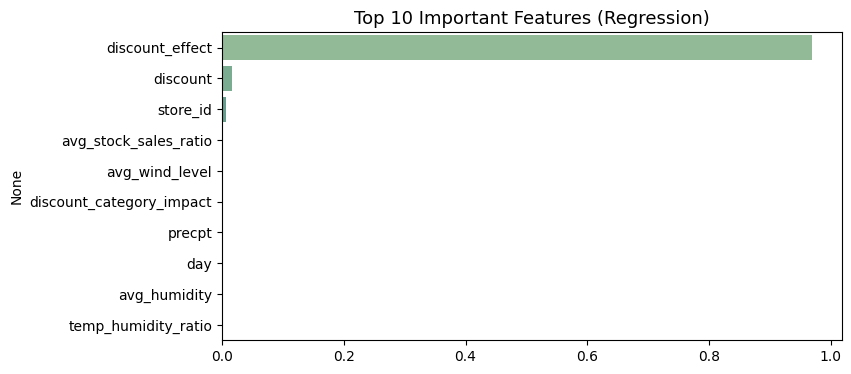

In [104]:
importances = pd.Series(best_reg.feature_importances_, index=X_reg.columns).sort_values(ascending=False).head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=importances.values, y=importances.index, palette="crest")
plt.title("Top 10 Important Features (Regression)", fontsize=13)
plt.show()

# CLASSIFICATION MODEL — Predict Sales Level (High/Low)

In [105]:
X_clf = df.drop(columns=["sale_amount", "sales_level"], errors="ignore")
y_clf = df["sales_level"]

In [106]:
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf)

In [107]:
param_grid_clf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 15, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

In [108]:
grid_clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_clf, cv=3, n_jobs=-1, verbose=0)
grid_clf.fit(X_train_clf, y_train_clf)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [10, 15, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 200, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [109]:
best_clf = grid_clf.best_estimator_
y_pred_clf = best_clf.predict(X_test_clf)

In [110]:
print("\n CLASSIFICATION MODEL — Predicting Sales Level (High/Low)")
print(f"Best Parameters: {grid_clf.best_params_}")
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_clf):.4f}")
print("\nClassification Report:\n", classification_report(y_test_clf, y_pred_clf))


 CLASSIFICATION MODEL — Predicting Sales Level (High/Low)
Best Parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       219
           1       1.00      1.00      1.00       181

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



C:\Users\swati\AppData\Local\Temp\ipykernel_14940\2510859374.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=clf_importances.values, y=clf_importances.index, palette="mako")


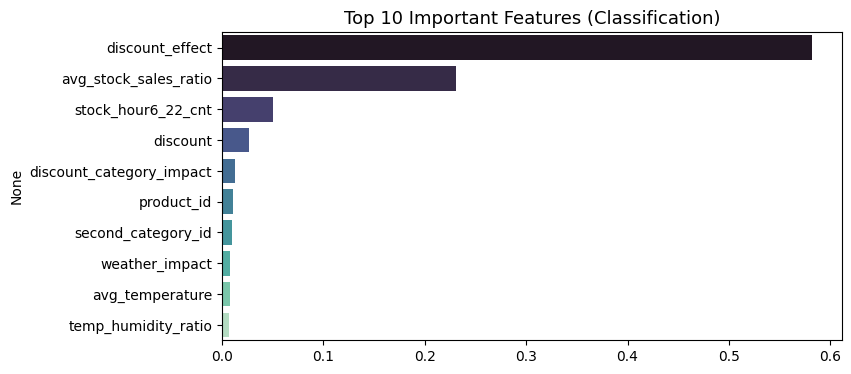

In [111]:
clf_importances = pd.Series(best_clf.feature_importances_, index=X_clf.columns).sort_values(ascending=False).head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=clf_importances.values, y=clf_importances.index, palette="mako")
plt.title("Top 10 Important Features (Classification)", fontsize=13)
plt.show()